<a href="https://colab.research.google.com/github/bonjon/DeepLearningProject/blob/main/rotatedmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/adambielski/GrouPy.git

Cloning into 'GrouPy'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 167 (delta 35), reused 33 (delta 33), pack-reused 119
Receiving objects: 100% (167/167), 141.59 KiB | 2.44 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
%cd GrouPy/
!python setup.py install
%cd ..

/content/GrouPy
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/groupy
copying groupy/__init__.py -> build/lib/groupy
creating build/lib/groupy/garray
copying groupy/garray/p4m_array.py -> build/lib/groupy/garray
copying groupy/garray/test_garray.py -> build/lib/groupy/garray
copying groupy/garray/Z2_array.py -> build/lib/groupy/garray
copying groupy/garray/finitegroup.py -> build/lib/groupy/garray
copying groupy/garray/C4_array.py -> build/lib/groupy/garray
copying groupy/garray/__init__.py -> build/lib/groupy/garray
copying groupy/garray/p4_array.py -> build/lib/groupy/garray
copying groupy/garray/garray.py -> build/lib/groupy/garray
copying groupy/garray/D4_array.py -> build/lib/groupy/garray
copying groupy/garray/matrix_garray.py -> build/lib/groupy/garray
creating build/lib/groupy/gconv
copying groupy/gconv/make_gconv_indices.py -> build/lib/groupy/gconv
copying groupy/gconv/__init__.py -> build/lib/groupy/gconv
creating build/li

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable

In [4]:
trainset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.RandomRotation((90, 270)),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
testset = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.RandomRotation((90, 270)),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


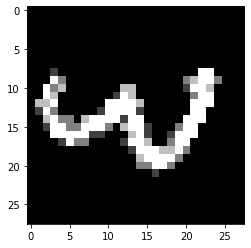

Label: 3


In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [7]:
from groupy.gconv.pytorch_gconv.splitgconv2d import P4ConvZ2, P4ConvP4
from groupy.gconv.pytorch_gconv.pooling import plane_group_spatial_max_pooling

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = P4ConvZ2(1, 10, kernel_size=3)
        self.conv2 = P4ConvP4(10, 10, kernel_size=3)
        self.conv3 = P4ConvP4(10, 20, kernel_size=3)
        self.conv4 = P4ConvP4(20, 20, kernel_size=3)
        self.fc1 = nn.Linear(4*4*20*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = plane_group_spatial_max_pooling(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = plane_group_spatial_max_pooling(x, 2, 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [11]:
log_freq = 10

def train(epoch, optimizer, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
from tqdm.notebook import tqdm

run_training = True  #@param {type:"boolean"}
SAVE_PATH = '/content/'  #@param {type:"string"}
epoch_num = 50
test_freq = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if run_training:
      net = Net()
      net.to(device)
      learning_rate = 0.01
      momentum = 0.5
      optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
        
      for i in tqdm(range(epoch_num)):
          train(i, optimizer, net)

          if (i+1) % test_freq == 0:
            print('\n-------------Network Test-------------')
            net.eval()
            test(net)
            net.train()
            print('----------------------------------------\n')
      torch.save(net.state_dict(), SAVE_PATH + 'pretrained.pt')
                    

  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.336439
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.306561
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.242265
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.153983
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.087790
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.927298
Train Epoch: 0 [3840/60000 (6%)]	Loss: 1.853319
Train Epoch: 0 [4480/60000 (7%)]	Loss: 1.641063
Train Epoch: 0 [5120/60000 (9%)]	Loss: 1.650319
Train Epoch: 0 [5760/60000 (10%)]	Loss: 1.866045
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.512446
Train Epoch: 0 [7040/60000 (12%)]	Loss: 1.354888
Train Epoch: 0 [7680/60000 (13%)]	Loss: 1.431390
Train Epoch: 0 [8320/60000 (14%)]	Loss: 1.211817
Train Epoch: 0 [8960/60000 (15%)]	Loss: 1.238769
Train Epoch: 0 [9600/60000 (16%)]	Loss: 1.171700
Train Epoch: 0 [10240/60000 (17%)]	Loss: 1.097300
Train Epoch: 0 [10880/60000 (18%)]	Loss: 1.344882
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.961276
Train Epoch: 0 [12160/60000 (20%)]	Loss: 1.061495
Train Epoch: 0 [12800/60000 (

In [14]:
model = Net()
model.load_state_dict(torch.load('/content/pretrained.pt'))
model = model.to(device)

In [15]:
model.train()
test(model)


Test set: Average loss: 0.0477, Accuracy: 9848/10000 (98%)



In [16]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [18]:
with torch.no_grad():
  output = model(example_data.to(device))

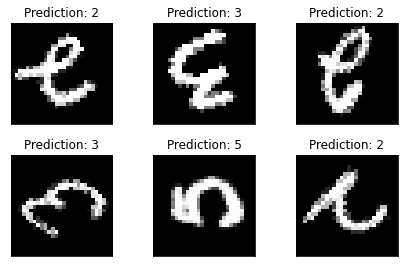

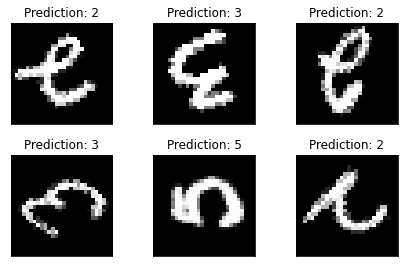

In [19]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig